In [2]:

import torch
import scanpy as sc
import pandas as pd
import scipy.sparse as sp
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scvi
from skmisc.loess import loess
import seaborn as sns

#import torchmetrics
#import pytorch_lightning

C:\Users\D_F\miniconda3\envs\sc_solo_env\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
C:\Users\D_F\miniconda3\envs\sc_solo_env\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
C:\Users\D_F\miniconda3\envs\sc_solo_env\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
C:\Users\D_F\miniconda3\envs\sc_solo_env\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
C:\Users\D_F\miniconda3\envs\sc_solo_env\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_mtx from `annda

In [3]:
adata_all = sc.read_h5ad("updated_adata_marked_with_doublets.h5ad")
adata_all

AnnData object with n_obs × n_vars = 74453 × 26147
    obs: 'sample_id', 'region', 'brain_region', 'batch', 'donor_id', 'braak_stage', 'sex', 'age', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'n_genes', 'solo_doublet', 'solo_singlet'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_cells'

## before batch corection/scvi usage i need to select HVGs first

In [4]:
import scanpy as sc
import scvi

# Filter HVGs — this works directly on raw data!
sc.pp.highly_variable_genes(
    adata_all,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset=True
)


In [ ]:
sc.pp.normalize_total(adata_all, target_sum=1e4)
sc.pp.log1p(adata_all)


In [7]:
sc.pp.pca(adata_all, n_comps=30, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_all, n_neighbors=10, n_pcs=30, random_state=0)




In [9]:
sc.tl.umap(adata_all, min_dist=0.4, random_state=0)

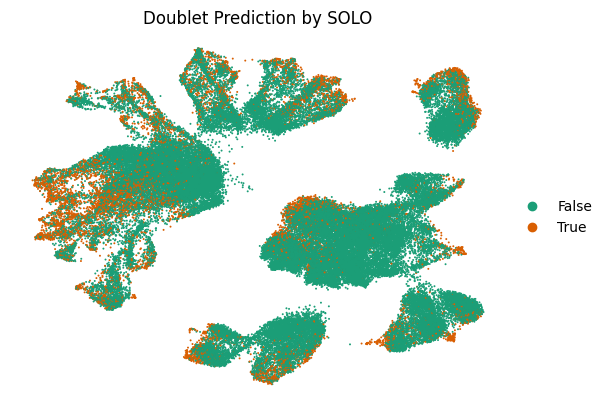

<Figure size 640x480 with 0 Axes>

In [10]:
sc.pl.umap(
    adata_all,
    color="solo_doublet",
    size=8,               # larger point size
    frameon=False,        # remove axis border
    title="Doublet Prediction by SOLO",
    palette=["#1b9e77", "#d95f02"],  # optional if values are binary
    legend_loc="right margin",      # keeps legend off the plot
)

import matplotlib.pyplot as plt
plt.savefig("Fig_umap_doublets.pdf", dpi=300, bbox_inches="tight")


In [11]:
adata_all

AnnData object with n_obs × n_vars = 74453 × 2000
    obs: 'sample_id', 'region', 'brain_region', 'batch', 'donor_id', 'braak_stage', 'sex', 'age', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'n_genes', 'solo_doublet', 'solo_singlet'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'solo_doublet_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## SCVI batch corection code:

In [13]:
import torch
print(torch.cuda.is_available())


True


In [14]:
adata_all = sc.read_h5ad("updated_adata_marked_with_doublets.h5ad")

adata_all.layers["counts"] = adata_all.X.copy()  # much cheaper than .raw



# Now continue with HVG filtering and scVI
sc.pp.highly_variable_genes(adata_all, flavor="seurat_v3", n_top_genes=2000, subset=True)
scvi.model.SCVI.setup_anndata(adata_all, batch_key="sample_id")
model = scvi.model.SCVI(adata_all, n_latent=30)
model.train(max_epochs=400, batch_size=512)




adata_all.obsm["X_scVI"] = model.get_latents()
sc.pp.neighbors(adata_all, use_rep="X_scVI")
sc.tl.umap(adata_all, min_dist=0.4, random_state=0)

# Save figure
sc.pl.umap(adata_all, color="solo_doublet", size=8, frameon=False, show=False)
import matplotlib.pyplot as plt
plt.savefig("Fig_umap_doublets.pdf", dpi=300, bbox_inches="tight")

# ✅ Save everything to file (including .raw)
adata_all.write("adata_with_scvi_latent_and_raw.h5ad")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\D_F\miniconda3\envs\sc_solo_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


AttributeError: 'SCVI' object has no attribute 'get_latents'

In [15]:
import scvi
print(scvi.__version__)


1.3.0


In [16]:
adata_all.obsm["X_scVI"] = model.get_latents()

AttributeError: 'SCVI' object has no attribute 'get_latents'

In [17]:
print(type(model))


<class 'scvi.model._scvi.SCVI'>


In [18]:
model.save("updated_scvi_model/", overwrite=True)


In [4]:
import scvi

# Reload your original AnnData (must be same or very similar)
adata_all = sc.read_h5ad("updated_adata_marked_with_doublets.h5ad")

sc.pp.highly_variable_genes(adata_all, flavor="seurat_v3", n_top_genes=2000, subset=True)

# Re-setup anndata (must match the original setup: batch_key, etc.)
scvi.model.SCVI.setup_anndata(adata_all, batch_key="sample_id")

# Load trained model
model = scvi.model.SCVI.load("updated_scvi_model/", adata=adata_all)

# Get latent space again (fast!)
adata_all.obsm["X_scVI"] = model.get_latent_representation()


INFO     File updated_scvi_model/model.pt already downloaded                                                       


In [6]:
adata_all.obsm["X_scVI"]

array([[-1.3848722 ,  0.92456526, -1.1013039 , ...,  1.0490966 ,
        -1.5766025 , -0.38211173],
       [-0.22605012, -0.31705856, -1.4656676 , ..., -1.9624538 ,
         1.1072198 , -0.35284114],
       [-0.14589557,  0.00526923, -1.3668956 , ...,  2.1779044 ,
        -1.3933905 ,  0.03019761],
       ...,
       [ 0.27869257, -0.90383923,  1.0399779 , ...,  0.12929463,
        -0.6309812 , -0.30369627],
       [ 0.78372085,  0.182652  , -0.5212834 , ...,  0.8247222 ,
        -0.63086337,  0.12337608],
       [-1.8832608 ,  0.23257571, -0.8436388 , ...,  0.93193924,
        -0.28795353, -0.4691583 ]], dtype=float32)

In [ ]:
adata_all

In [1]:
adata_all.write("updated_adata_after_scvi.h5ad", compression="gzip")


NameError: name 'adata_all' is not defined

# Plots

In [3]:
adata_all = sc.read_h5ad("updated_adata_after_scvi.h5ad")

In [4]:
sc.pp.neighbors(adata_all, use_rep="X_scVI", n_neighbors=10, method='umap')
sc.tl.umap(adata_all, min_dist=0.4, random_state=0)


Saved to umap_doublet_panel.pdf / .png


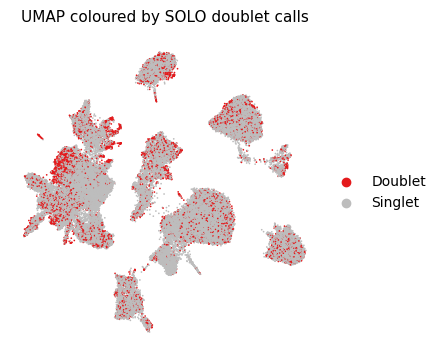

In [5]:
import scanpy as sc
from matplotlib import rcParams

# 0)  Create a categorical column with nicer labels
adata_all.obs["doublet_status"] = adata_all.obs["solo_doublet"].map(
    {True: "Doublet", False: "Singlet"}
).astype("category")

# 1)  Build the kNN/UMAP if it doesn't exist yet
if "X_umap" not in adata_all.obsm:
    # use scVI latent space if present; else PCA space
    sc.pp.neighbors(adata_all, use_rep="X_scVI" if "X_scVI" in adata_all.obsm else None,
                    n_neighbors=15)
    sc.tl.umap(adata_all, min_dist=0.4)

# 2)  Plot – colour singlets grey, doublets red
ax = sc.pl.umap(
    adata_all,
    color="doublet_status",
    palette={"Singlet": "#bdbdbd", "Doublet": "#e41a1c"},  # light-grey & red
    size=6,           # dot size; raise if the plot looks too sparse
    frameon=False,    # drop axes
    legend_loc="right margin",
    show=False,       # keep figure in memory
)

# 3)  Style & save
fig = ax.figure
fig.set_size_inches(4.0, 4.0)                # 4×4-inch square
ax.set_title("UMAP coloured by SOLO doublet calls", fontsize=11, pad=12)

# PDFs are vector – perfect for print
fig.savefig("umap_doublet_panel2.pdf", bbox_inches="tight")

# High-resolution raster (600 dpi PNG) if the journal insists on PNG/TIFF
fig.savefig("umap_doublet_panel2.png", dpi=600, bbox_inches="tight")

print("Saved to umap_doublet_panel.pdf / .png")


## Visualize known features (e.g., doublets or brain region)

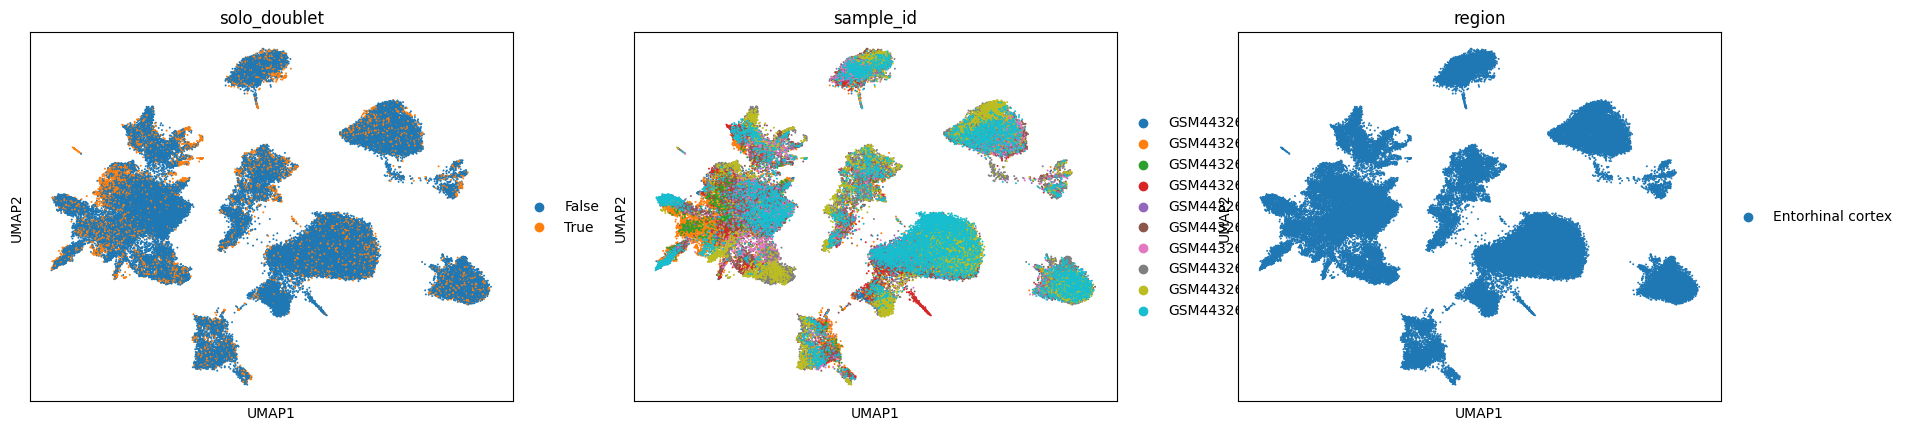

In [9]:
sc.pl.umap(adata_all, color=["solo_doublet", "sample_id", "region"], size=8)


## Cluster the cells

C:\Users\D_F\AppData\Local\Temp\ipykernel_22660\3368036198.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_all, resolution=1.0)


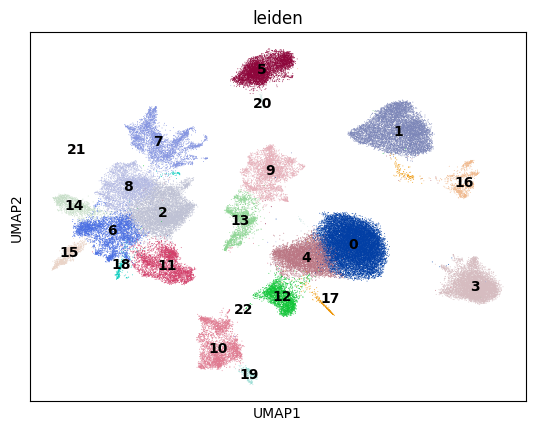

In [10]:
sc.tl.leiden(adata_all, resolution=1.0)
sc.pl.umap(adata_all, color="leiden", legend_loc="on data")


In [11]:
adata_all

AnnData object with n_obs × n_vars = 74453 × 2000
    obs: 'sample_id', 'region', 'brain_region', 'batch', 'donor_id', 'braak_stage', 'sex', 'age', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'n_genes', 'solo_doublet', 'solo_singlet', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'solo_doublet_colors', 'sample_id_colors', 'region_colors', 'leiden', 'leiden_colors'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

# Time to remove doublets

In [12]:
# Option 1: If it's boolean True/False
adata_all = adata_all[adata_all.obs["solo_doublet"] == False].copy()
adata_all.write("updated_adata_after_scvi_doublets_removed.h5ad", compression="gzip")


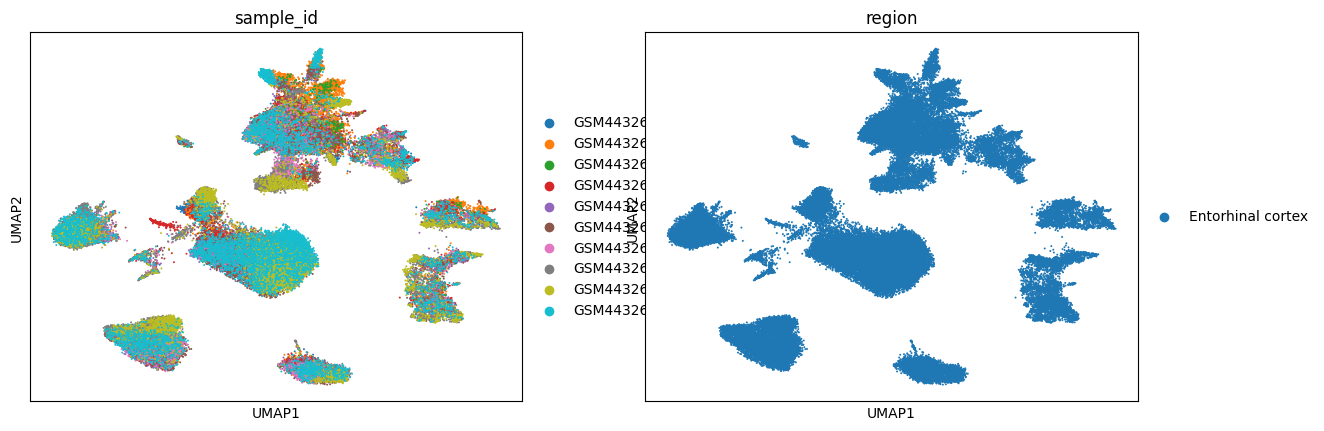

In [13]:
sc.pp.neighbors(adata_all, use_rep="X_scVI", n_neighbors=10)
sc.tl.umap(adata_all, min_dist=0.4, random_state=0)
sc.pl.umap(adata_all, color=["sample_id", "region"], size=8)


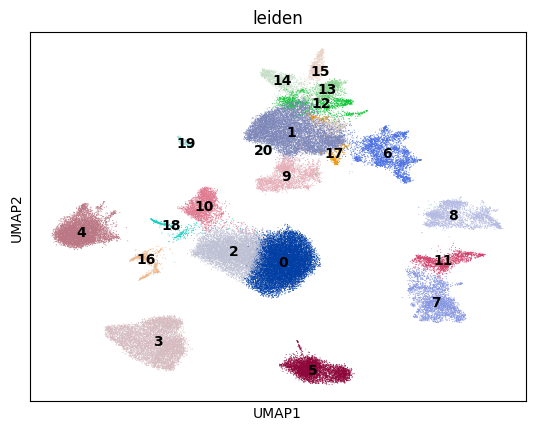

In [14]:
sc.tl.leiden(adata_all, resolution=1.0)
sc.pl.umap(adata_all, color="leiden", legend_loc="on data")


In [15]:
adata_all

AnnData object with n_obs × n_vars = 64086 × 2000
    obs: 'sample_id', 'region', 'brain_region', 'batch', 'donor_id', 'braak_stage', 'sex', 'age', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'n_genes', 'solo_doublet', 'solo_singlet', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'solo_doublet_colors', 'sample_id_colors', 'region_colors', 'leiden', 'leiden_colors'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'distances', 'connectivities'

In [17]:
adata = sc.read_h5ad("adata_annotated_broad_cell_type.h5ad")

In [18]:
adata

AnnData object with n_obs × n_vars = 60305 × 2000
    obs: 'sample_id', 'region', 'brain_region', 'batch', 'donor_id', 'braak_stage', 'sex', 'age', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score_scrublet', 'predicted_doublet_scrublet', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'solo_doublet', 'solo_singlet', 'solo_predicted_doublet', 'n_counts', 'log1p_total_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1.0', 'celltype_annot', 'celltype_by_chatgpt', 'assigned_celltype', 'supercluster_name', 'broad_cell_type_v2'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', '

## Slhouette scores

In [20]:
from sklearn.metrics import silhouette_score

# Silhouette based on batch (sample_id)
score_batch = silhouette_score(adata_all.obsm["X_scVI"], adata_all.obs["sample_id"])
print("Silhouette (batch sample_id):", score_batch)

Silhouette (batch sample_id): -0.02661007


## knn batch mixing entropy

In [21]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy

def knn_batch_entropy(adata, label_key="sample_id", k=50):
    X = adata.obsm["X_scVI"]
    labels = adata.obs[label_key].values
    knn = NearestNeighbors(n_neighbors=k+1).fit(X)
    indices = knn.kneighbors(X, return_distance=False)[:, 1:]

    entropies = []
    for idx in indices:
        neighbor_labels = labels[idx]
        _, counts = np.unique(neighbor_labels, return_counts=True)
        ent = entropy(counts, base=2)
        entropies.append(ent)

    return np.mean(entropies)

entropy_score = knn_batch_entropy(adata_all, label_key="sample_id", k=50)
print("kNN batch mixing entropy:", entropy_score)


kNN batch mixing entropy: 2.2364024668732814


# Plots again

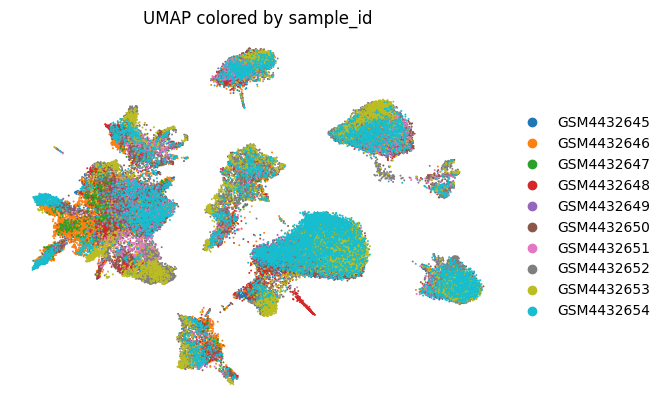

In [6]:
sc.pl.umap(
    adata_all,
    color="sample_id",
    size=8,
    frameon=False,
    legend_loc="right margin",
    title="UMAP colored by sample_id",
    palette="tab10",  # or use a custom palette if needed
    show=False
)

plt.savefig("Fig_umap_sample_id.pdf", dpi=300, bbox_inches="tight")


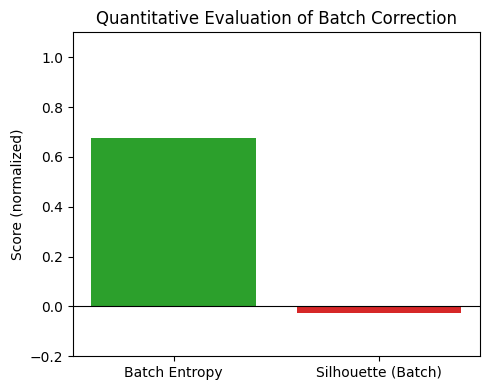

In [13]:
import matplotlib.pyplot as plt

# Values from your evaluation
entropy = 2.24
silhouette = -0.027
max_entropy = np.log2(10)  # for 10 batches

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(
    ["Batch Entropy", "Silhouette (Batch)"],
    [entropy / max_entropy, silhouette],
    color=["#2ca02c", "#d62728"]
)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel("Score (normalized)")
ax.set_ylim(-0.2, 1.1)
ax.set_title("Quantitative Evaluation of Batch Correction")
plt.tight_layout()
plt.savefig("Fig_batch_correction_scores.pdf", dpi=300)


C:\Users\D_F\AppData\Local\Temp\ipykernel_17540\2644754628.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata_all.obs.groupby("sample_id", group_keys=False).apply(lambda x: x.sample(n=min(1000, len(x)), random_state=0))
C:\Users\D_F\AppData\Local\Temp\ipykernel_17540\2644754628.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = adata_all.obs.groupby("sample_id", group_keys=False).apply(lambda x: x.sample(n=min(1000, len(x)), random_state=0))


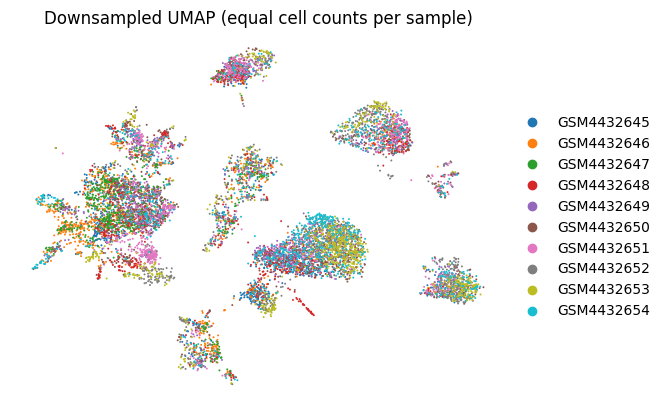

In [7]:
import pandas as pd

# Sample 1000 cells per sample_id
df = adata_all.obs.groupby("sample_id", group_keys=False).apply(lambda x: x.sample(n=min(1000, len(x)), random_state=0))
adata_sub = adata_all[df.index].copy()

# Now plot
sc.pl.umap(
    adata_sub,
    color="sample_id",
    size=8,
    frameon=False,
    legend_loc="right margin",
    title="Downsampled UMAP (equal cell counts per sample)",
    show=False
)
plt.savefig("Fig_umap_sample_id_downsampled.pdf", dpi=300, bbox_inches="tight")


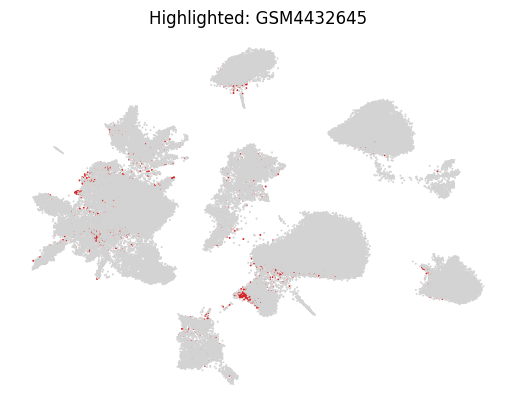

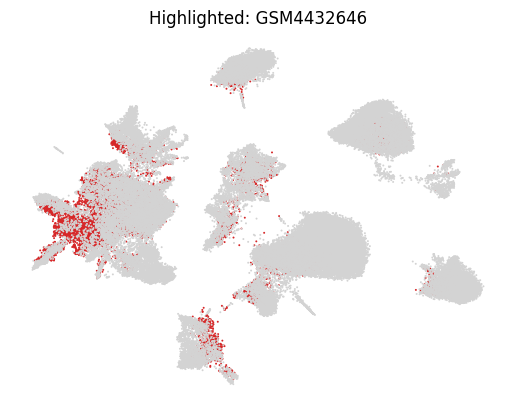

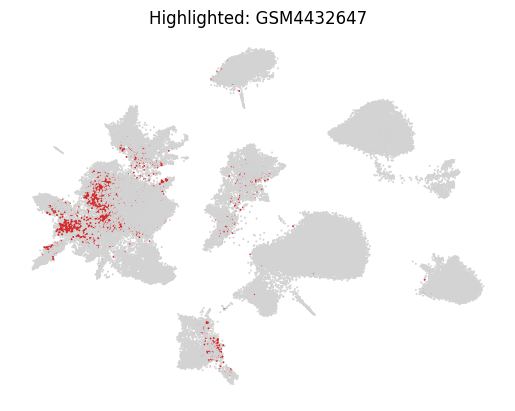

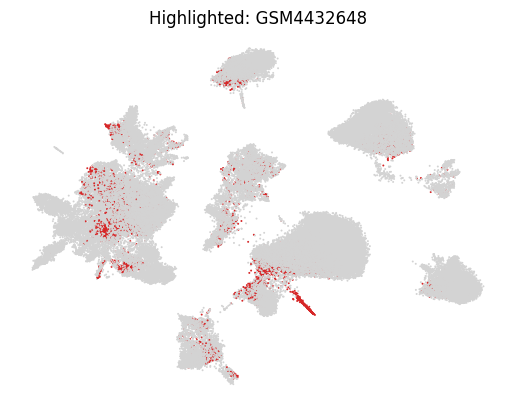

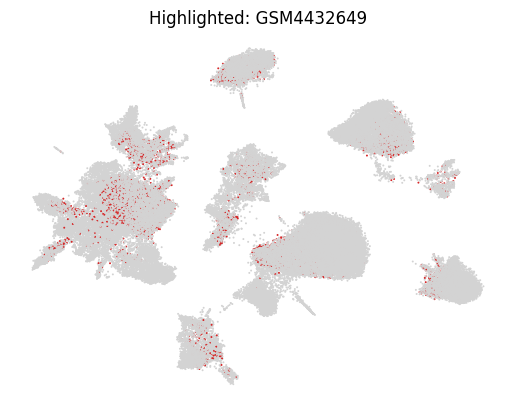

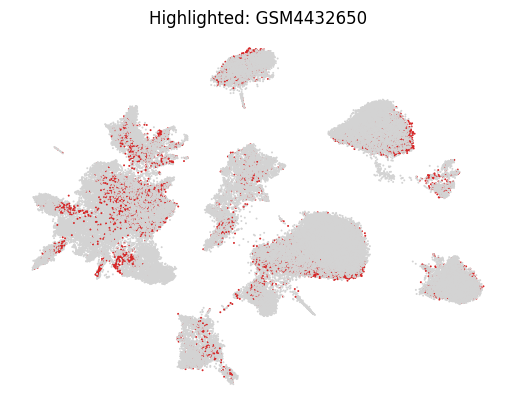

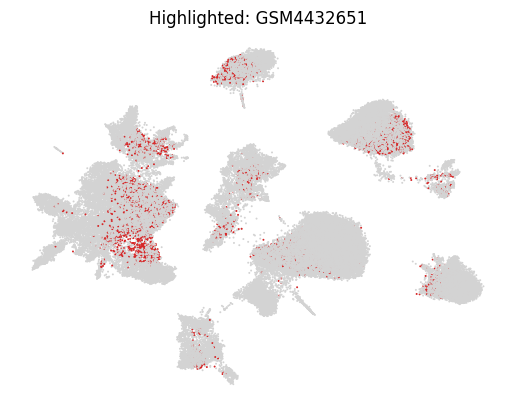

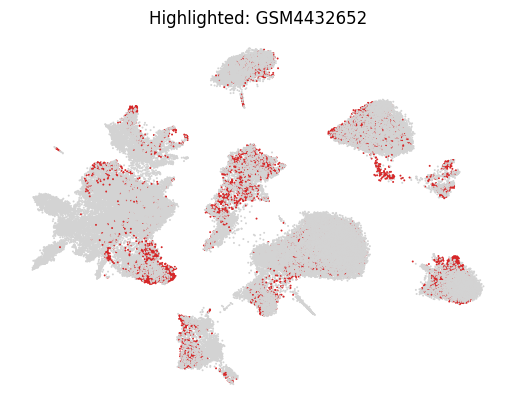

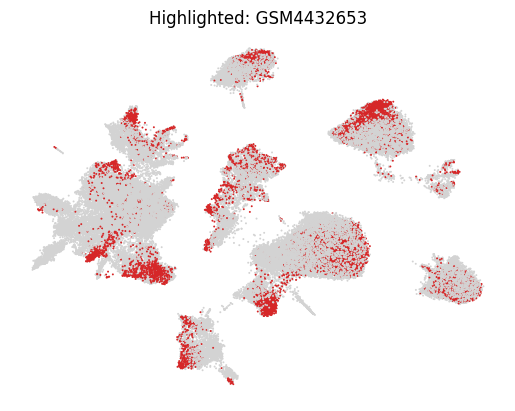

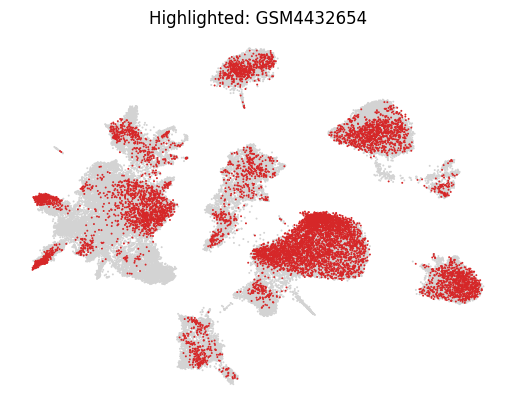

In [8]:
from matplotlib import pyplot as plt

sample_ids = adata_all.obs["sample_id"].unique().tolist()

# Assign grey to all samples
base_palette = {sid: "#D3D3D3" for sid in sample_ids}

# Highlight one sample at a time
for sid in sample_ids:
    highlight_palette = base_palette.copy()
    highlight_palette[sid] = "#d62728"  # red for highlight

    sc.pl.umap(
        adata_all,
        color="sample_id",
        palette=highlight_palette,
        size=8,
        frameon=False,
        legend_loc=None,
        title=f"Highlighted: {sid}",
        show=False
    )
    plt.savefig(f"Fig_umap_sample_highlight_{sid}.pdf", dpi=300, bbox_inches="tight")


In [10]:
sample_sizes = adata_all.obs["sample_id"].value_counts()
print(sample_sizes)


sample_id
GSM4432652    12623
GSM4432653    11203
GSM4432646     9669
GSM4432654     9173
GSM4432650     8139
GSM4432645     5996
GSM4432648     5425
GSM4432649     5224
GSM4432651     4233
GSM4432647     2768
Name: count, dtype: int64


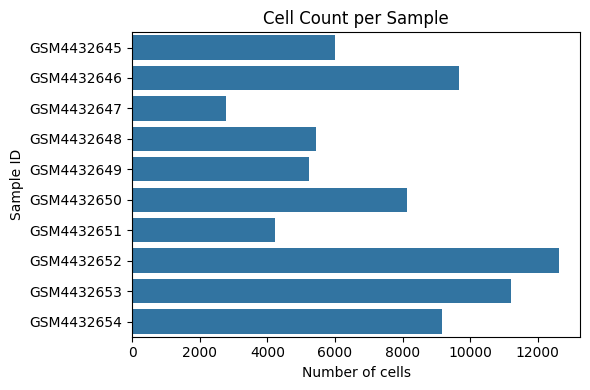

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(x=sample_sizes.values, y=sample_sizes.index, color="#1f77b4")
plt.xlabel("Number of cells")
plt.ylabel("Sample ID")
plt.title("Cell Count per Sample")
plt.tight_layout()
plt.savefig("Fig_sample_size_barplot.pdf", dpi=300)


In [30]:
import pandas as pd

# Sample 1000 cells per donor (or less if needed)
df = adata_all.obs.groupby("sample_id", group_keys=False).apply(
    lambda x: x.sample(n=min(1000, len(x)), random_state=0)
)
adata_balanced = adata_all[df.index].copy()

# Now do UMAP plots or highlight again


C:\Users\D_F\AppData\Local\Temp\ipykernel_22660\3446101063.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata_all.obs.groupby("sample_id", group_keys=False).apply(
C:\Users\D_F\AppData\Local\Temp\ipykernel_22660\3446101063.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = adata_all.obs.groupby("sample_id", group_keys=False).apply(


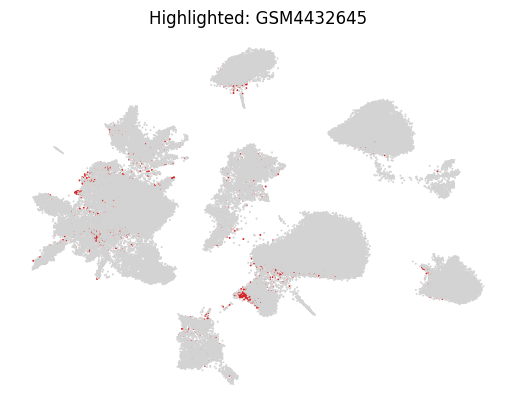

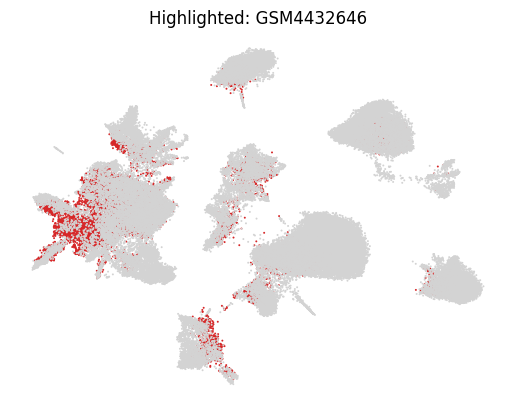

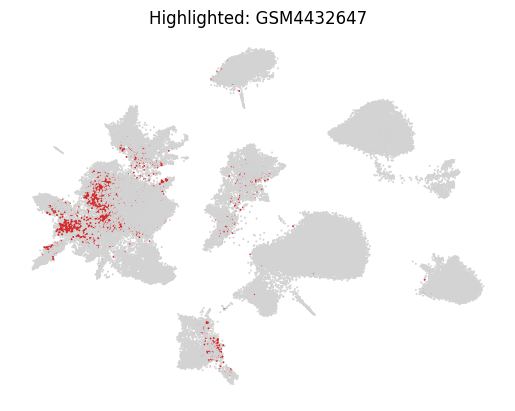

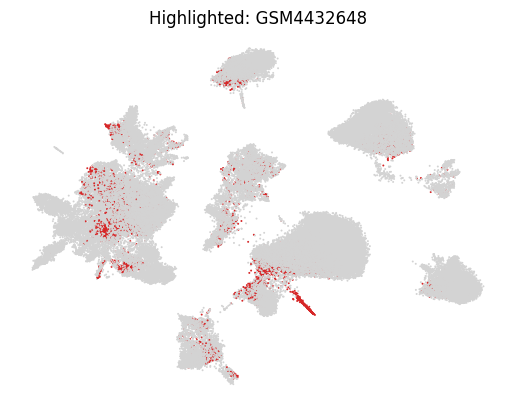

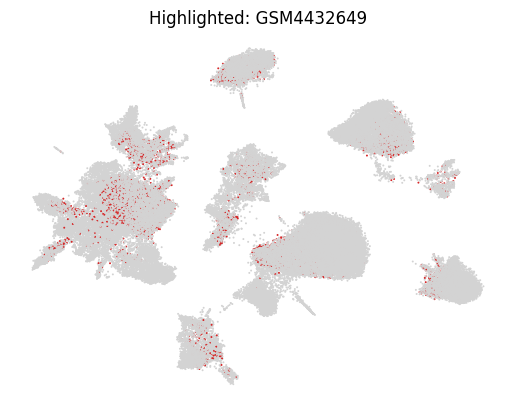

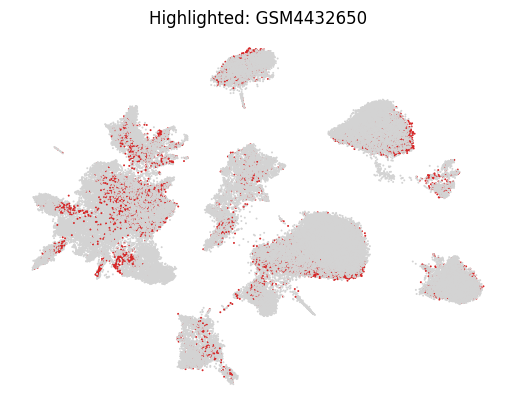

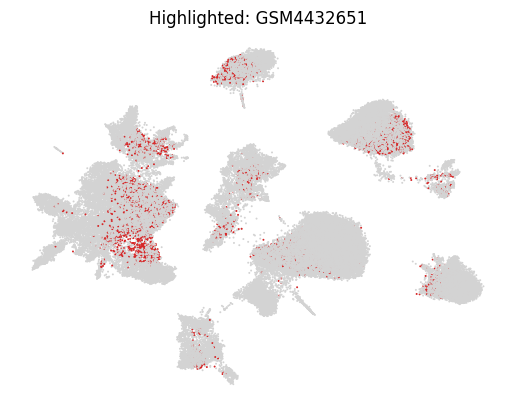

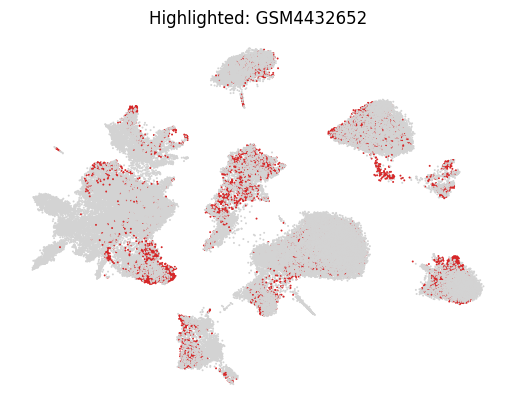

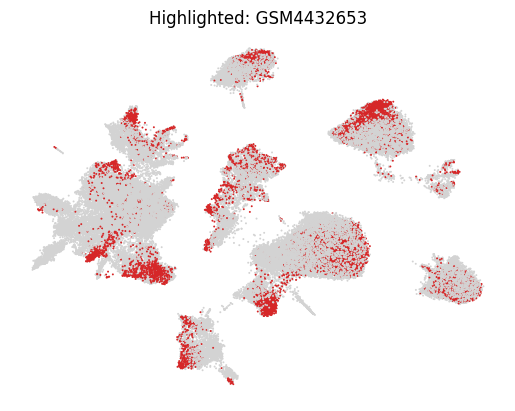

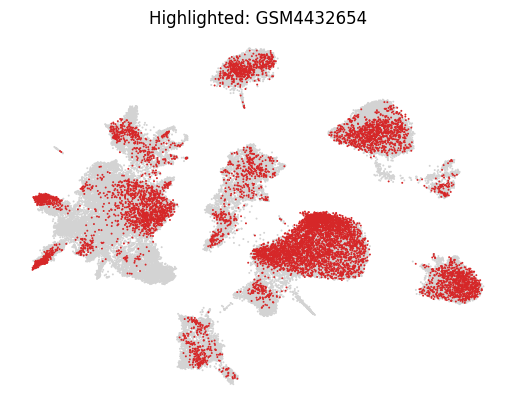

In [12]:
from matplotlib import pyplot as plt

sample_ids = adata_all.obs["sample_id"].unique().tolist()

# Assign grey to all samples
base_palette = {sid: "#D3D3D3" for sid in sample_ids}

# Highlight one sample at a time
for sid in sample_ids:
    highlight_palette = base_palette.copy()
    highlight_palette[sid] = "#d62728"  # red for highlight

    sc.pl.umap(
        adata_all,
        color="sample_id",
        palette=highlight_palette,
        size=8,
        frameon=False,
        legend_loc=None,
        title=f"Highlighted: {sid}",
        show=False
    )
    plt.savefig(f"Fig_umap_sample_highlight_balanced_{sid}.pdf", dpi=300, bbox_inches="tight")


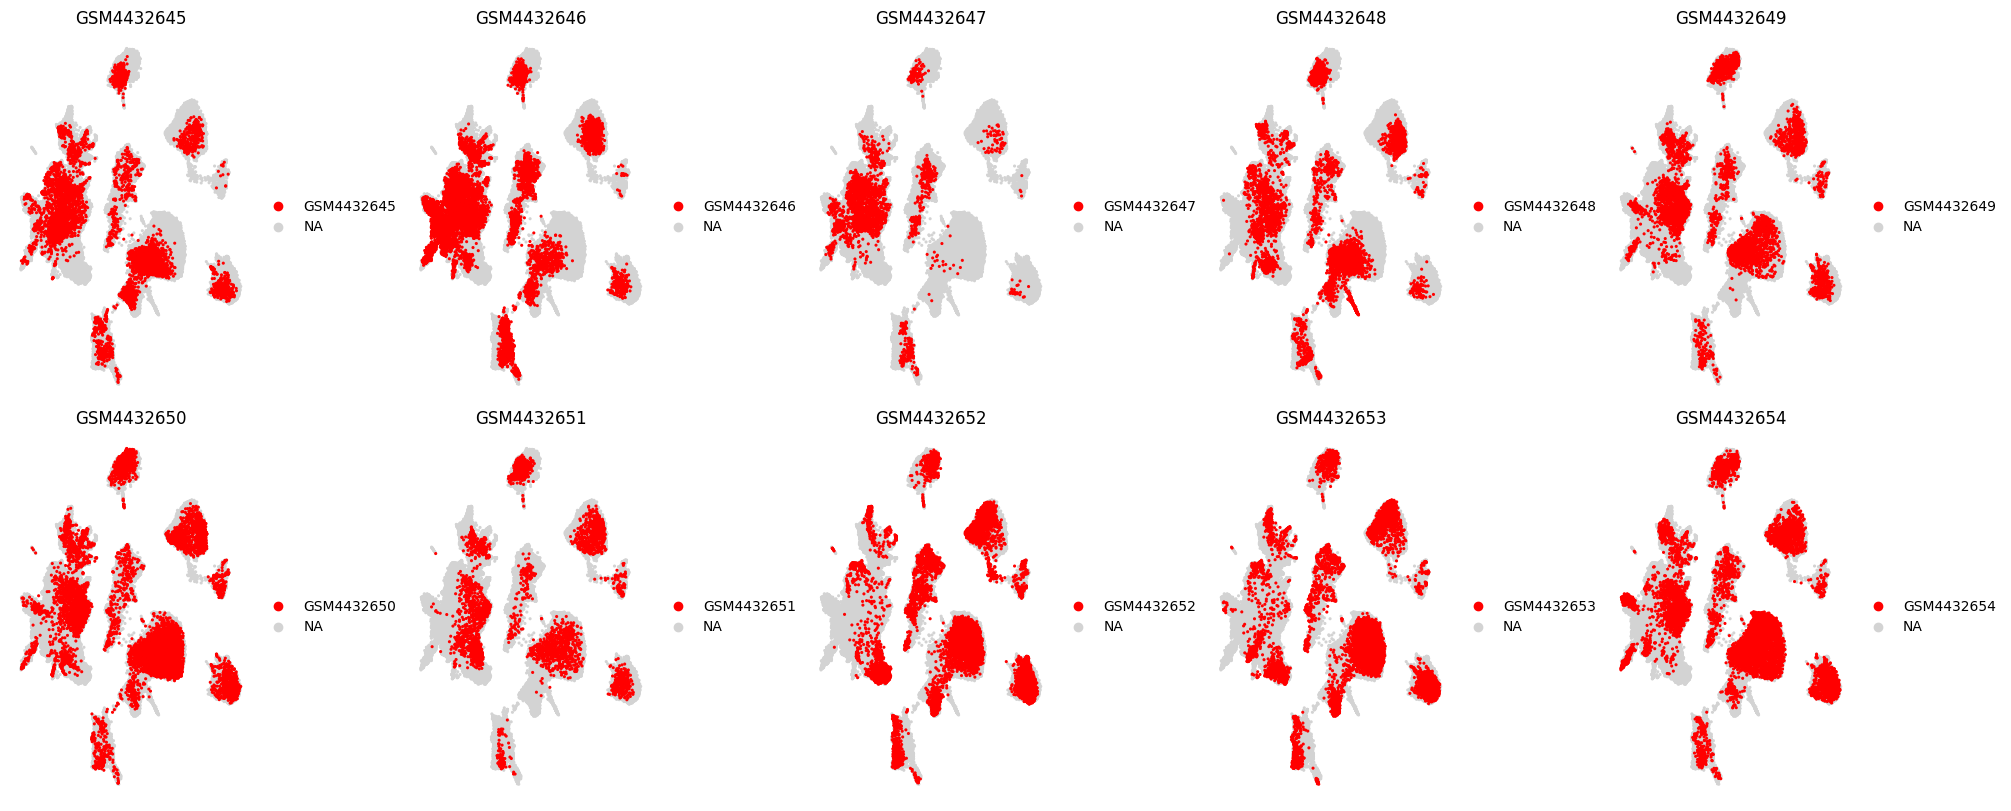

In [21]:
import scanpy as sc
import matplotlib.pyplot as plt


donors = adata.obs['sample_id'].unique().tolist()
n_donors = len(donors)

ncols = 5
nrows = (n_donors + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4), constrained_layout=True)
axes = axes.flatten()

for i, donor in enumerate(donors):
    ax = axes[i]
    sc.pl.umap(
        adata,
        color='sample_id',
        groups=[donor],
        palette=['red'],
        ax=ax,
        show=False,
        size=20,
        frameon=False,
        title=donor
    )

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.savefig("facet_umap_per_donor_pretty.pdf")
plt.show()


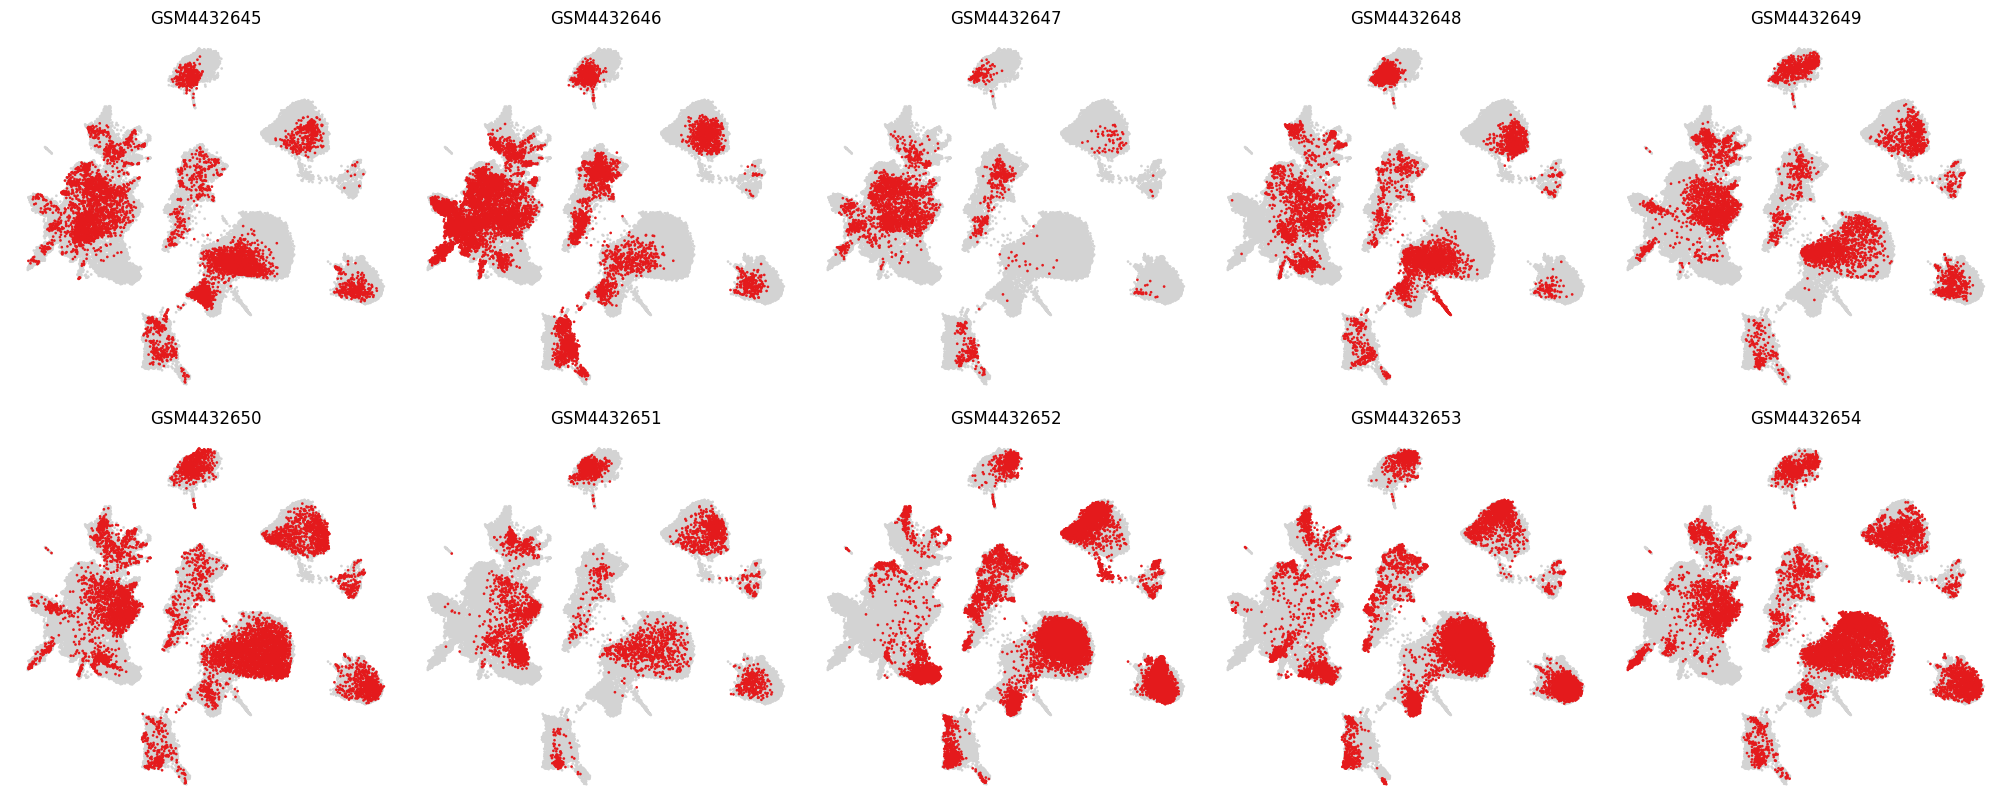

In [22]:
import scanpy as sc
import matplotlib.pyplot as plt

# Unique donor labels
donors = adata.obs['sample_id'].unique().tolist()
n_donors = len(donors)

# Layout configuration
ncols = 5
nrows = (n_donors + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4), constrained_layout=True)
axes = axes.flatten()

# Generate 1 panel per donor
for i, donor in enumerate(donors):
    ax = axes[i]
    sc.pl.umap(
        adata,
        color='sample_id',
        groups=[donor],
        palette=['#E41A1C'],  # cleaner red
        ax=ax,
        show=False,
        size=15,
        frameon=False,
        title=donor,
        legend_loc=None
    )

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Save to PDF and PNG
#fig.savefig("facet_umap_per_donor.pdf", dpi=150, bbox_inches='tight')
fig.savefig("facet_umap_per_donor.png", dpi=150, bbox_inches='tight')
plt.show()
